### Standard GRU Model 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular


/Users/amalshar/miniforge3/envs/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Enable eager execution
tf.compat.v1.enable_eager_execution()

In [3]:
# Data Loading & Preprocessing

# Load preprocessed dataset (update the path as needed)
df = pd.read_csv('/Users/amalshar/Desktop/USD/Spring 2025/Artificial Intelligence/AI Project/data/energy_weather_preprocessed.csv')

# Define features and target variable
FEATURES = ['current', 'voltage', 'reactive_power', 'apparent_power', 
            'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
            'temp_humidity_interaction', 'hour', 'day', 'month', 'year',
            'active_power_lag_1', 'active_power_lag_2', 'active_power_lag_3',
            'active_power_rolling_mean', 'active_power_rolling_std']
TARGET = 'active_power'

# Extract features and target
X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)

# Apply MinMax Scaling to both features and target
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [4]:
# Create Sequential Data for GRU
time_steps = 3  # Number of time steps in each sequence
features_dim = X_scaled.shape[1]

# Create sequences using a sliding window approach:
# Each sample consists of the previous 'time_steps' rows, and the target is the subsequent value.
X_seq = np.array([X_scaled[i - time_steps:i] for i in range(time_steps, len(X_scaled))])
y_seq = y_scaled[time_steps:]

# Split Data into Train/Validation/Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# Build GRU Model (Fixed Hyperparameters)
def build_gru_model():
    model = Sequential()
    # First GRU layer: returns sequences to allow stacking of another GRU layer
    model.add(GRU(units=64, activation='tanh', return_sequences=True, input_shape=(time_steps, features_dim)))
    model.add(Dropout(0.2))
    
    # Second GRU layer: last layer in stack does not return sequences
    model.add(GRU(units=32, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense output layer for regression (active power prediction)
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse', metrics=['mae', 'mape'])
    return model

# Build and summarize the GRU model
model_gru = build_gru_model()
model_gru.summary()

/Users/amalshar/miniforge3/envs/dlenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 3, 64)          │        16,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,145 (102.13 KB)

 Trainable params: 26,145 (102.13 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train GRU Model
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-5)

history = model_gru.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# history = model_gru.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=32,
#     validation_data=(X_val, y_val),
#     verbose=1
# )

Epoch 1/500
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0032 - mae: 0.0343 - mape: 67.8249 - val_loss: 0.0014 - val_mae: 0.0152 - val_mape: 24.2670 - learning_rate: 1.0000e-04
Epoch 2/500
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.0015 - mae: 0.0184 - mape: 73.9561 - val_loss: 0.0014 - val_mae: 0.0161 - val_mape: 29.4622 - learning_rate: 1.0000e-04
Epoch 3/500
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.0015 - mae: 0.0169 - mape: 90.9274 - val_loss: 0.0013 - val_mae: 0.0149 - val_mape: 24.4718 - learning_rate: 1.0000e-04
Epoch 4/500
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.0014 - mae: 0.0161 - mape: 28.7908 - val_loss: 0.0014 - val_mae: 0.0159 - val_mape: 24.5665 - learning_rate: 1.0000e-04
Epoch 5/500
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.0014 - mae: 0.0158 - mape: 75.2079 - val_loss: 0.0013 - val_mae: 0.0140 - val_mape: 23.9860 - learning_rate: 1.0000e-04
Epoch 6/500
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - 

In [7]:
# Evaluate Model Performance
loss = model_gru.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Generate predictions and convert back to original scale
y_pred = model_gru.predict(X_test)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Compute evaluation metrics
mse_val = mean_squared_error(y_test_original, y_pred_original)
mae_val = mean_absolute_error(y_test_original, y_pred_original)
r2_val = r2_score(y_test_original, y_pred_original)

print(f'Mean Squared Error (MSE): {mse_val}')
print(f'Mean Absolute Error (MAE): {mae_val}')
print(f'R-squared (R2): {r2_val}')

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 2s 765us/step - loss: 0.0014 - mae: 0.0130 - mape: 20.4543
Test Loss: [0.001355429063551128, 0.012810149230062962, 20.468019485473633]
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step
Mean Squared Error (MSE): 0.001355430593065806
Mean Absolute Error (MAE): 0.012810134089580667
R-squared (R2): 0.694033442929374


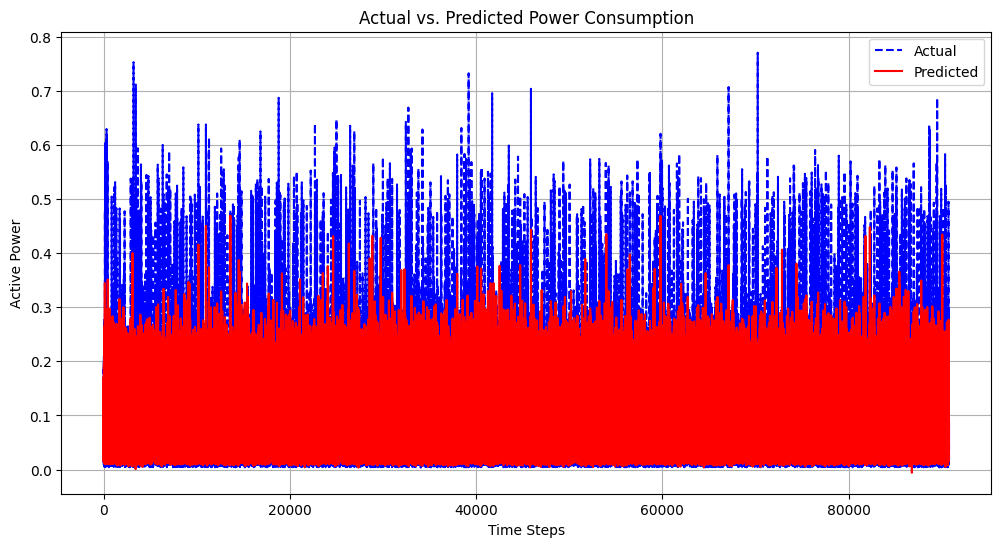

In [8]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", linestyle='dashed', color='blue')
plt.plot(y_pred_original, label="Predicted", linestyle='solid', color='red')

plt.xlabel("Time Steps")
plt.ylabel("Active Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid()
plt.show()

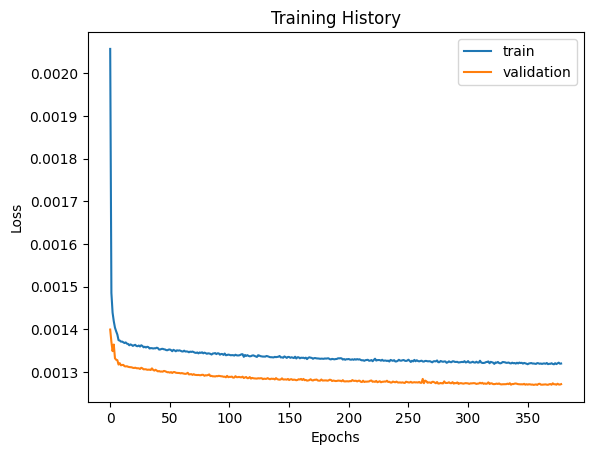

In [9]:
# Visualize training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()

In [12]:
features_dim = len(FEATURES)

In [13]:
# LIME Explanation for the LSTM Model

# Flatten the sequential data from (samples, time_steps, features) to (samples, time_steps*features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Generate feature names for flattened data: e.g., current_t1, voltage_t1, ...
feature_names_flat = []
for t in range(time_steps):
    for feature in FEATURES:
        feature_names_flat.append(f"{feature}_t{t+1}")

# Define a wrapper function that reshapes the flat data back to the sequential shape before predicting
def predict_wrapper(flat_data):
    n_samples = flat_data.shape[0]
    reshaped = flat_data.reshape(n_samples, time_steps, features_dim)  # Use features_dim instead of FEATURES
    preds = model_gru.predict(reshaped)
    return preds.ravel()  # Return a 1D array

# Create a LimeTabularExplainer for regression
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names_flat,
    mode='regression'
)

# Explain the prediction for one test instance (using the first instance as an example)
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10  # Adjust to show top contributing features
)

# Display the LIME explanation
try:
    exp.show_in_notebook(show_table=True, show_all=False)
except ImportError:
    from IPython.display import display, HTML
    display(HTML(exp.as_html()))

# Alternatively, print the explanation as text in the console
print("LIME Explanation (Feature Contributions):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


LIME Explanation (Feature Contributions):
year_t2 <= 0.50: 0.0739
year_t3 <= 0.50: -0.0375
apparent_power_t3 <= 0.06: -0.0319
year_t1 <= 0.50: 0.0294
current_t3 <= 0.05: -0.0290
active_power_lag_1_t3 <= 0.05: -0.0174
active_power_rolling_mean_t3 <= 0.07: -0.0139
active_power_lag_2_t3 <= 0.05: -0.0093
month_t3 <= 0.27: -0.0078
reactive_power_t3 <= 0.05: 0.0074


In [14]:
# Save Lime explanation as HTML
lime_html = exp.as_html()   
with open('exp16_lime_explanation.html', 'w') as f:
    f.write(lime_html)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 5s 705us/step


 10%|█         | 1/10 [00:06<00:56,  6.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 639us/step


 20%|██        | 2/10 [00:11<00:45,  5.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step


 30%|███       | 3/10 [00:16<00:38,  5.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step


 40%|████      | 4/10 [00:21<00:31,  5.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step


 50%|█████     | 5/10 [00:27<00:26,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 628us/step


 60%|██████    | 6/10 [00:32<00:21,  5.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 627us/step


 70%|███████   | 7/10 [00:37<00:15,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 623us/step


 80%|████████  | 8/10 [00:42<00:10,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 650us/step


 90%|█████████ | 9/10 [00:47<00:05,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 4s 623us/step


100%|██████████| 10/10 [00:53<00:00,  5.30s/it]


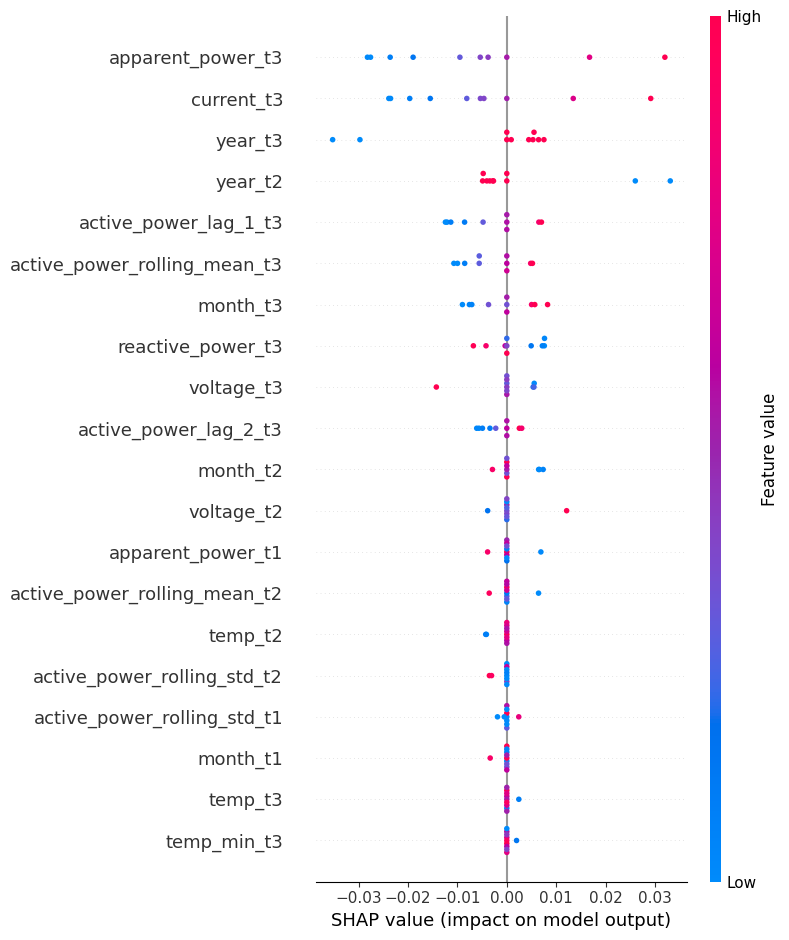

In [15]:
# Define a prediction wrapper
def predict_shap(data):
    # Reshape the flat data back to the original shape (samples, time_steps, features)
    reshaped_data = data.reshape(data.shape[0], time_steps, features_dim)
    return model_gru.predict(reshaped_data).flatten()

# Use a subset of X_train for the explainer
explainer = shap.KernelExplainer(predict_shap, X_train[:100].reshape(100, -1))  # Flatten for KernelExplainer

# Calculate SHAP values for a subset of the test data
shap_values = explainer.shap_values(X_test[:10].reshape(10, -1))  # Flatten for KernelExplainer

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test[:10].reshape(10, -1), feature_names=feature_names_flat)